# Gavin Kendal-Freedman

## Research question/interests

**My main interest is how different chemicals effect air quality ratings, specifically the main hazardous components in fuels for motor vehicles or stoves like natural gas/gasoline/diesel fuels (benzene, toluene, propane, methane, sulfurs/oxides of nitrogens, 2,2,4-Trimethylpentane (octane from standard gasoline)), and also potentially common organic solvents/reagents that are used in manufacturing (methacrylates, chloroform/methyl chloroform, acetylene, nitric acid), and how these different particulates effect AQI. Further, I want to see if there is a significant difference in air quality change across time in urban vs rural areas (not just if urban areas have better/worse air quality), based on specific particulates in the first part, and if there is any correlations between asthma rates in different areas and the levels of pollutants there (not across time because the asthma data does not have a time series attached to it).**

### Rough Plan for Data Analysis

1. (Already done as part of loading) Combine all EPA data files into one dataframe
1. Remove all rows that do not contain the parameters of interest (see above)
1. Remove columns that are mostly null/na/nan/missing values or are not interesting to the analysis
1. For locations that have multiple observations for a parameter in a year, average them and all statistics about the measurements for the year
1. Isolate a single metric for each parameter of interest (preferably "Observed Values"), preferably an overall average for the year and not the mean for daily maximums
1. Check for any correlations between the parameters of interest to other parameters of interest, and the AQI
1. Check changes in concentrations over time and see if there are any correlations between the changes in concentrations and the AQI
1. Geo-plot the change in AQI over time for each location, with an overlay showing the change in a normalization and aggregation of the parameters of interest
1. For 2020, geo-plot the AQI and the parameters of interest for each location and overlay the asthma rates for each location

In [1]:
from importlib.util import find_spec as _spec
USE_CACHED = True
RELOAD_UTILS = True
ARROW_INSTALLED = bool(_spec("pyarrow"))
PYOGRIO_INSTALLED = bool(_spec("pyogrio"))
gpd_read_args = {} 
if PYOGRIO_INSTALLED:
    gpd_read_args |= {"engine":"pyogrio", "use_arrow": ARROW_INSTALLED}

In [2]:
# Imports
from itertools import chain
from typing import TYPE_CHECKING

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

# this is a little bit of a hack to get typing hints for the projects function code since
# relative imports won't work properly and the runtime solution doesn't work
# for static analysis (type checking) since its not runtime
if TYPE_CHECKING:
    from .code import project_functions1 as utils
else:
    __import__("sys").path.append("./code") # add the code folder to path
    import project_functions1 as utils

In [3]:
# Setup seaborn/matplotlib theme information
sns.set_theme(style="darkgrid", font_scale=1.5) # type: ignore

In [57]:
# Load the data using the function
if RELOAD_UTILS:
    from importlib import reload

    reload(utils)
if USE_CACHED and (utils.PROJECT_ROOT / "data/processed/processed1.csv").exists():
    df = utils.load_preprocessed(
        utils.PROJECT_ROOT / "data/processed/geodata1.geojson",
        utils.PROJECT_ROOT / "data/processed/processed1.csv",
        use_pyarrow=ARROW_INSTALLED,
        gpd_kwargs=gpd_read_args,
    )
    # df: gpd.GeoDataFrame = gpd.read_file(utils.PROJECT_ROOT / "data/processed/processed1.csv", **gpd_read_args)  # type: ignore
else:
    df: gpd.GeoDataFrame = utils.load_and_process(
        range(2011, 2023), use_pyarrow=ARROW_INSTALLED, gpd_kwargs=gpd_read_args
    )
healthdata = utils.load_and_process_healthdata(use_pyarrow=ARROW_INSTALLED)
shapedata: gpd.GeoDataFrame = gpd.read_file(utils.PROJECT_ROOT / "data/raw/contiguous-usa.geojson", **gpd_read_args)  # type: ignore

In [110]:
#Export data if data processing has changed
df.drop(columns="geometry").to_csv(utils.PROJECT_ROOT / "data/processed/processed1.csv", index=False)
df[["CBSAFP", "geometry"]].drop_duplicates().to_file(utils.PROJECT_ROOT / "data/processed/geodata1.geojson", driver='GeoJSON', engine="pyogrio")  

In [58]:
df2 = (
    df.pivot_table(
        values=["Arithmetic Mean"],  # pyright: ignore
        columns=["Parameter Name"],
        index=["CBSA Name", "Year"],
    )
    .droplevel(0, axis=1)
    .merge(
        df.drop(columns=["Arithmetic Mean", "Parameter Name"]),
        how="left",
        left_index=True,
        right_on=["CBSA Name", "Year"],
    )
).set_index(["Year", "CBSA Name"])
df2 = gpd.GeoDataFrame(df2, geometry=df2.geometry)  # type: ignore

In [72]:
parameters = [
    "Max AQI",
    "Ozone",
    "Ammonium compounds",
    "Carbon monoxide",
    "Heavy Metals",
    "Nitric oxides",
    "Nitrogen dioxide (NO2)",
    "Sulfur dioxide",
    "Various Particulates",
    "Benzenes",
]


In [30]:
projection=gcrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795)

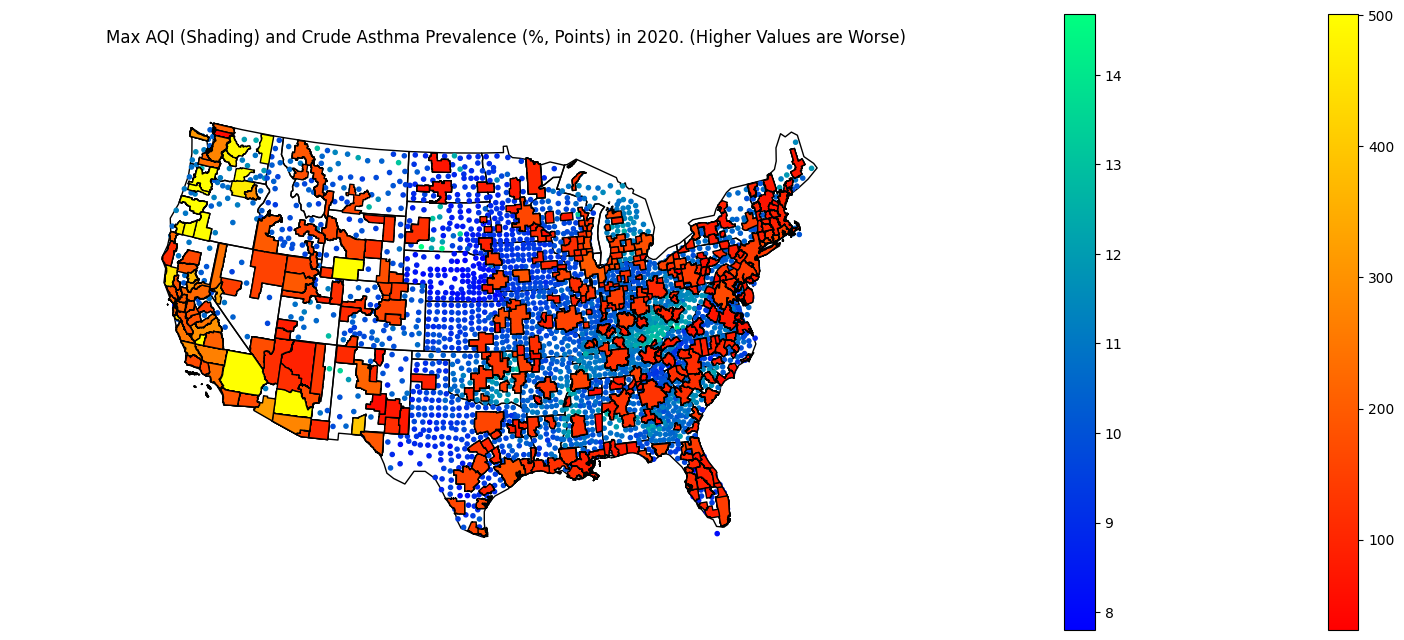

In [71]:
health_scatter = gplt.polyplot(shapedata, figsize=(20,8), projection=projection)
gplt.choropleth(
    df2.dropna(subset="Max AQI").loc[2020],
    hue="Max AQI",
    legend=True,
    ax=health_scatter,
    edgecolor="black",
    linewidth=1,
    cmap="autumn",
    projection=projection,
)
gplt.pointplot(
    healthdata,
    projection=projection,
    hue="Percentage",
    scale="Percentage",
    legend_var="hue",
    legend=True,
    limits=(3,3),
    cmap="winter",
    ax=health_scatter,
)
health_scatter.set_title("Max AQI (Shading) and Crude Asthma Prevalence (%, Points) in 2020. (Higher Values are Worse)")
None

Text(0.5, 0.98, 'Concentrations for various parameters divided by CBSA for 2020 (Shading)\n with Crude Asthma Prevalence Overlaid (%, Points) (Higher values are worse)')

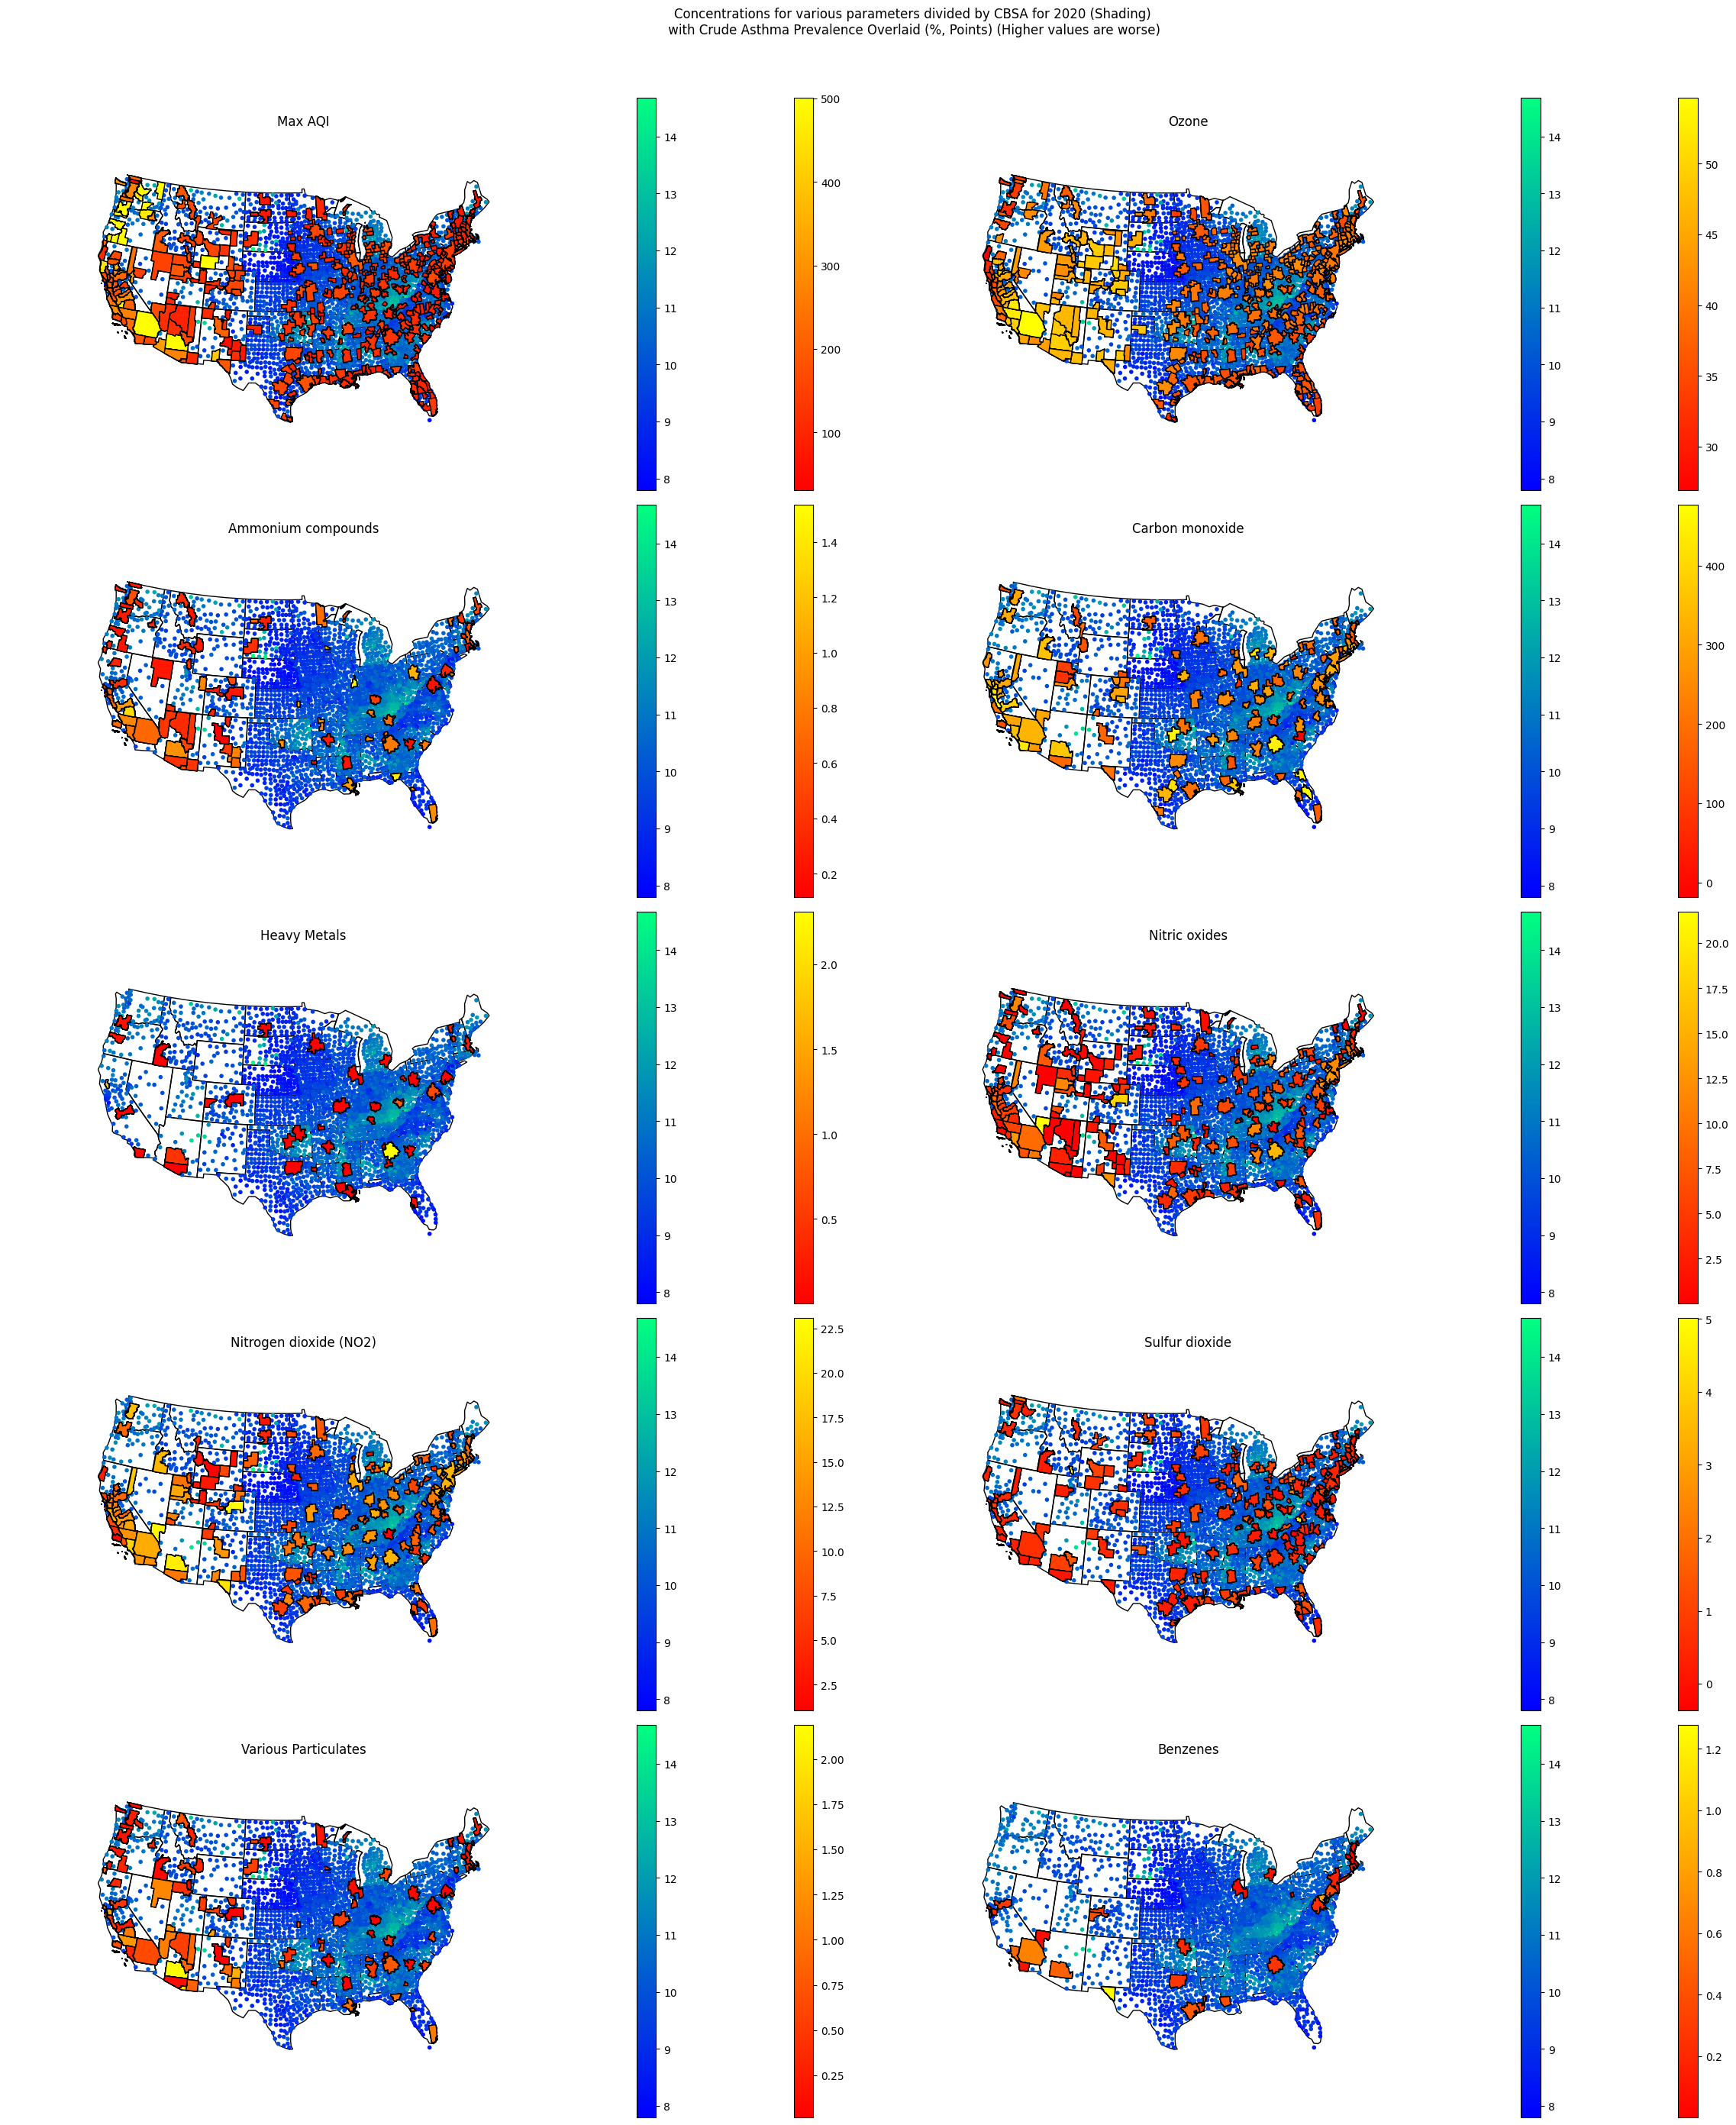

In [73]:
fig, axarr = plt.subplots(
    5,
    2,
    figsize=(24, 28),
    subplot_kw={"projection": projection},
    sharex=True,
    sharey=True,
    squeeze=True,
)
for param, ax in zip(parameters, chain.from_iterable(axarr)):
    gplt.polyplot(shapedata, ax=ax)
    gplt.choropleth(
        df2.dropna(subset=param).loc[2020],
        hue=param,
        legend=True,
        ax=ax,
        edgecolor="black",
        linewidth=1,
        cmap="autumn",
    )
    gplt.pointplot(
        healthdata,
        projection=projection,
        hue="Percentage",
        scale="Percentage",
        legend_var="hue",
        legend=True,
        limits=(3, 3),
        cmap="winter",
        ax=ax,
    )
    ax.set_title(label=param, fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle(
    "Concentrations for various parameters divided by CBSA for 2020 (Shading) with Crude Asthma Prevalence Overlaid (%, Points) (Higher values are worse)",
    va="baseline",
    fontsize=18,
)
None


In [ ]:
health_scatter = gplt.polyplot(shapedata, figsize=(20,12), projection=projection)
gplt.choropleth(
    df2.dropna(subset="Max AQI").loc[2015],
    hue="Max AQI",
    legend=True,
    ax=health_scatter,
    edgecolor="black",
    linewidth=1,
    cmap="autumn",
    projection=projection,
)
gplt.pointplot(
    healthdata,
    projection=projection,
    hue="Percentage",
    # scale="Percentage",
    # legend_var="hue",
    legend=True,
    # limits=(1,1),
    # cmap="winter",
    ax=health_scatter,
)

In [ ]:
fig2, axarr2 = plt.subplots(
    6,
    2,
    figsize=(24, 28),
    subplot_kw={"projection": projection},
    sharex=True,
    sharey=True,
    squeeze=True,
)
for year, ax in zip(list(range(2011, 2023)), chain.from_iterable(axarr2)):
    gplt.polyplot(
        shapedata,
        projection=gcrs.AlbersEqualArea(
            central_latitude=39.8282, central_longitude=-98.5795
        ),
        ax=ax,
    )
    gplt.choropleth(
        df2.loc[year],
        hue="Max AQI",
        ax=ax,
        legend=True,
        edgecolor="black",
        linewidth=0.1,
        cmap="autumn",
    )
    ax.set_title(f"{year}", fontsize=18)
fig2.tight_layout()
fig2.subplots_adjust(top=0.95)
fig2.suptitle("Max AQI by CBSA in the continental US for 2011 to 2022", fontsize=18)
None


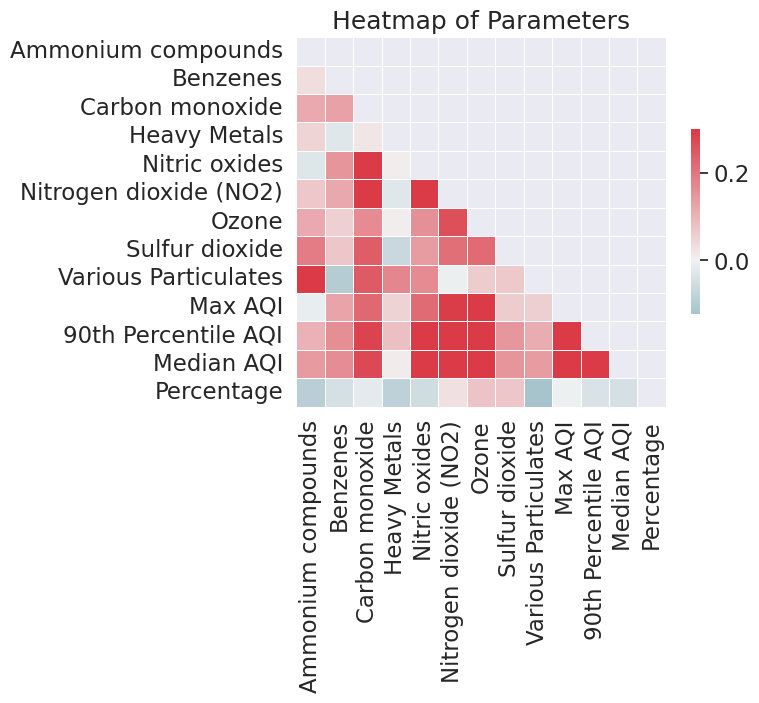

In [32]:
# grouped = (
#     df.loc[df["Parameter Name"].isin(whitelist)]
#     .drop_duplicates(subset=["CBSA Name", "Year", "Parameter Name"])
#     .groupby(["CBSA Name", "Parameter Name"], as_index=False)
# )["Arithmetic Mean"].agg("mean").pivot(
#     values="Arithmetic Mean",
#     columns="Parameter Name",
#     index="CBSA Name",
# )
import numpy as np

corr = ret[
    [
        "Ammonium compounds",
        "Benzenes",
        "Carbon monoxide",
        "Heavy Metals",
        "Nitric oxides",
        "Nitrogen dioxide (NO2)",
        "Ozone",
        "Sulfur dioxide",
        "Various Particulates",
        "Max AQI",
        "90th Percentile AQI",
        "Median AQI",
        "Percentage",
    ]
].corr()

# Generate a mask for the top right so we only generate one correlation per
# pair of factors.
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Generate custom color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create figure using seaborn:
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
heatmap.set(title="Heatmap of Parameters")
None
